In [20]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
import pandas as pd
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [2]:
# 读取并整理表格数据 输出为csv文件
df = pd.read_excel('./data/城市燃气小时负荷统计2021年.xls', index_col=None, header=None)
new_df = df[3:].iloc[:719, :25].reset_index(drop=True)
cols = ['date', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
        '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00',
        '22:00:00', '23:00:00', '00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
        '05:00:00', '06:00:00', '07:00:00', '08:00:00']
new_dataset = []
for i in range(719):
    for j in range(24):
        if j < 15:
            new_dataset.append([new_df[0][i].strftime("%m/%d/%Y") + ' ' + cols[j + 1], new_df[j + 1][i]])
        elif i == 718:
            new_dataset.append(['01/11/2021 ' + cols[j + 1], new_df[j + 1][i]])
        else:
            new_dataset.append([new_df[0][i + 1].strftime("%m/%d/%Y") + ' ' + cols[j + 1], new_df[j + 1][i]])
df = DataFrame(new_dataset, columns=['time', 'amount'])
df.to_csv('./data/城市燃气小时负荷统计.csv', index=False)

In [3]:
# 读取时间数据的格式化
def parser(x):
    return datetime.strptime(x, '%m/%d/%Y %H:%M:%S')

series = read_csv('data/城市燃气小时负荷统计.csv', header=0, parse_dates=[0], index_col=None, squeeze=True, 
                  date_parser=parser)
series = series.dropna()
series = series.reset_index(drop=True)

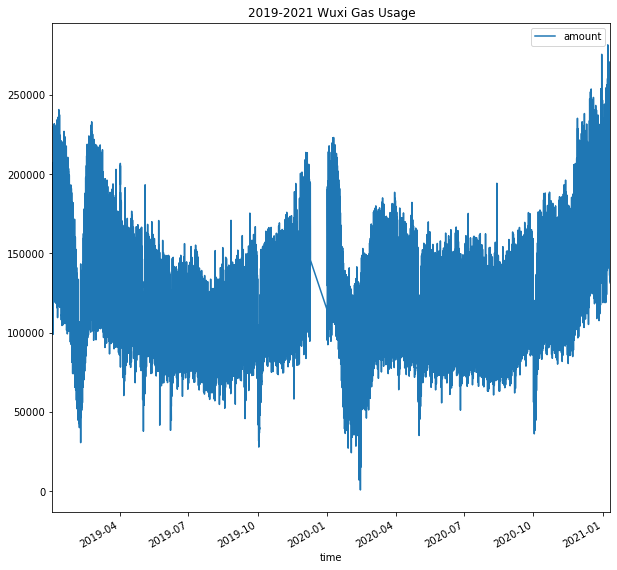

In [4]:
# 画折线图
series.plot('time', 'amount', title='2019-2021 Wuxi Gas Usage', figsize=(10,10));

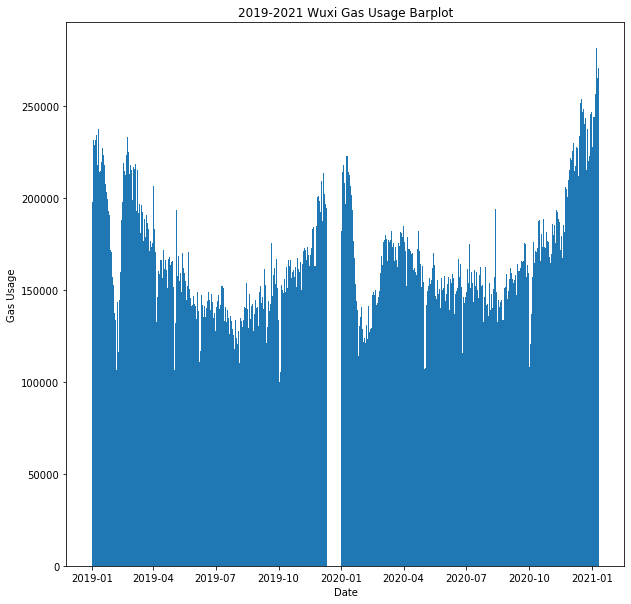

In [5]:
# 画柱状图
plt.figure(figsize=(10, 10))
plt.bar(series['time'], series['amount'])
plt.title('2019-2021 Wuxi Gas Usage Barplot')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.show()

In [390]:
# 转换成差分数据
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# 逆差分
def inverse_difference(history, yhat):  # 历史数据，预测数据，差分间隔
    arr = [history[0]]
    for i in range(len(yhat)):
        arr.append(history[i] + yhat[i])
    return np.array(arr)

In [6]:
# 转换成监督数据，四列数据，3->1，三组预测一组
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    print(agg)
    return agg

In [7]:
raw_value = series['amount'].values
value = raw_value.astype('float32')
# value = difference(raw_value, 1) # 转换成差分数据
# 标准化/放缩 特征值在（0,1）之间
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(value.reshape(-1, 1))

In [8]:
# 用3小时数据预测一小时数据，1个特征值
n_hours = 7
n_features = 1
# 构造一个3->1的监督学习型数据
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
reframed.dropna(inplace=True)

       var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN   0.443310   
3            NaN        NaN        NaN        NaN   0.443310   0.594629   
4            NaN        NaN        NaN   0.443310   0.594629   0.667937   
...          ...        ...        ...        ...        ...        ...   
17239   0.864354   0.812042   0.693552   0.561830   0.521225   0.506177   
17240   0.812042   0.693552   0.561830   0.521225   0.506177   0.468468   
17241   0.693552   0.561830   0.521225   0.506177   0.468468   0.480009   
17242   0.561830   0.521225   0.506177   0.468468   0.480009   0.464170   
17243   0.521225   0.506177   0.468468   0.480009   0.464170   0.577246   

       var1(t-1)   var1(t)  
0            NaN  0.443310  
1       0.443310  0.594629  
2       0.59

In [130]:
# 用2019-01-01到2019-12-09的数据来训练
values = reframed.values
train = values[:8208]
test = values[8208:]
# split into input and outputs
n_obs = n_hours * n_features
# 有4=(4*1)列数据，取前3=(3*1) 列作为X，倒数第1列=(第4列)作为Y
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(8208, 7) (8208,)
(9029, 7) (9029,)


In [131]:
# 将数据转换为3D输入，timesteps=3，3条数据预测1条 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8208, 7, 1) (8208,) (9029, 7, 1) (9029,)


In [128]:
# 设计网络
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, input_shape=(None, 100), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
# model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='rmsprop')

In [132]:
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
# model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [133]:
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8208 samples, validate on 9029 samples
Epoch 1/50
 - 5s - loss: 0.1085 - mse: 0.0265 - mae: 0.1085 - mape: 24.6403 - val_loss: 0.0892 - val_mse: 0.0113 - val_mae: 0.0892 - val_mape: 32001.9844
Epoch 2/50
 - 3s - loss: 0.0750 - mse: 0.0086 - mae: 0.0750 - mape: 18.7890 - val_loss: 0.0811 - val_mse: 0.0093 - val_mae: 0.0811 - val_mape: 32444.3750
Epoch 3/50
 - 3s - loss: 0.0667 - mse: 0.0071 - mae: 0.0667 - mape: 16.4451 - val_loss: 0.0719 - val_mse: 0.0074 - val_mae: 0.0719 - val_mape: 32780.0898
Epoch 4/50
 - 3s - loss: 0.0605 - mse: 0.0062 - mae: 0.0605 - mape: 14.5858 - val_loss: 0.0657 - val_mse: 0.0064 - val_mae: 0.0657 - val_mape: 32750.6016
Epoch 5/50
 - 3s - loss: 0.0547 - mse: 0.0053 - mae: 0.0547 - mape: 13.1074 - val_loss: 0.0622 - val_mse: 0.0058 - val_mae: 0.0622 - val_mape: 32448.6133
Epoch 6/50
 - 3s - loss: 0.0514 - mse: 0.0047 - mae: 0.0514 - mape: 12.2326 - val_loss: 0.0577 - val_mse: 0.0050 - val_mae: 0.0577 - val_mape: 31452.8887
Epoch 7/50
 - 3s - loss: 0.0

In [134]:
score = model.evaluate(test_X, test_y)
print(score)

9029/9029 [==============================] - 2s 248us/step
[0.03937375887292659, 0.002708788262680173, 0.039373770356178284, 26650.8984375]


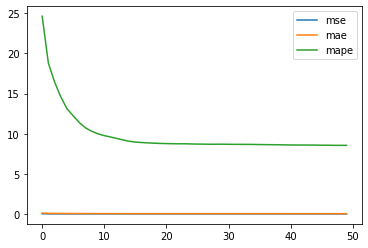

In [138]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['mape'], label='mape')
plt.legend()
plt.show()

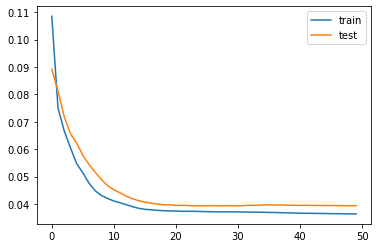

In [139]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [140]:
# 执行预测
yhat = model.predict(test_X)
# 将数据格式化成 n行 * 3列
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [141]:
# 将预测列据和后7列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# inv_yhat = inverse_difference(raw_value[8212:], inv_yhat)

In [142]:
test_y = test_y.reshape((len(test_y), 1))
# 将真实列据和后7列数据拼接，因后续逆缩放时，数据形状要符合 n行*8列 的要求
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
# 对拼接好的数据进行逆缩放
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

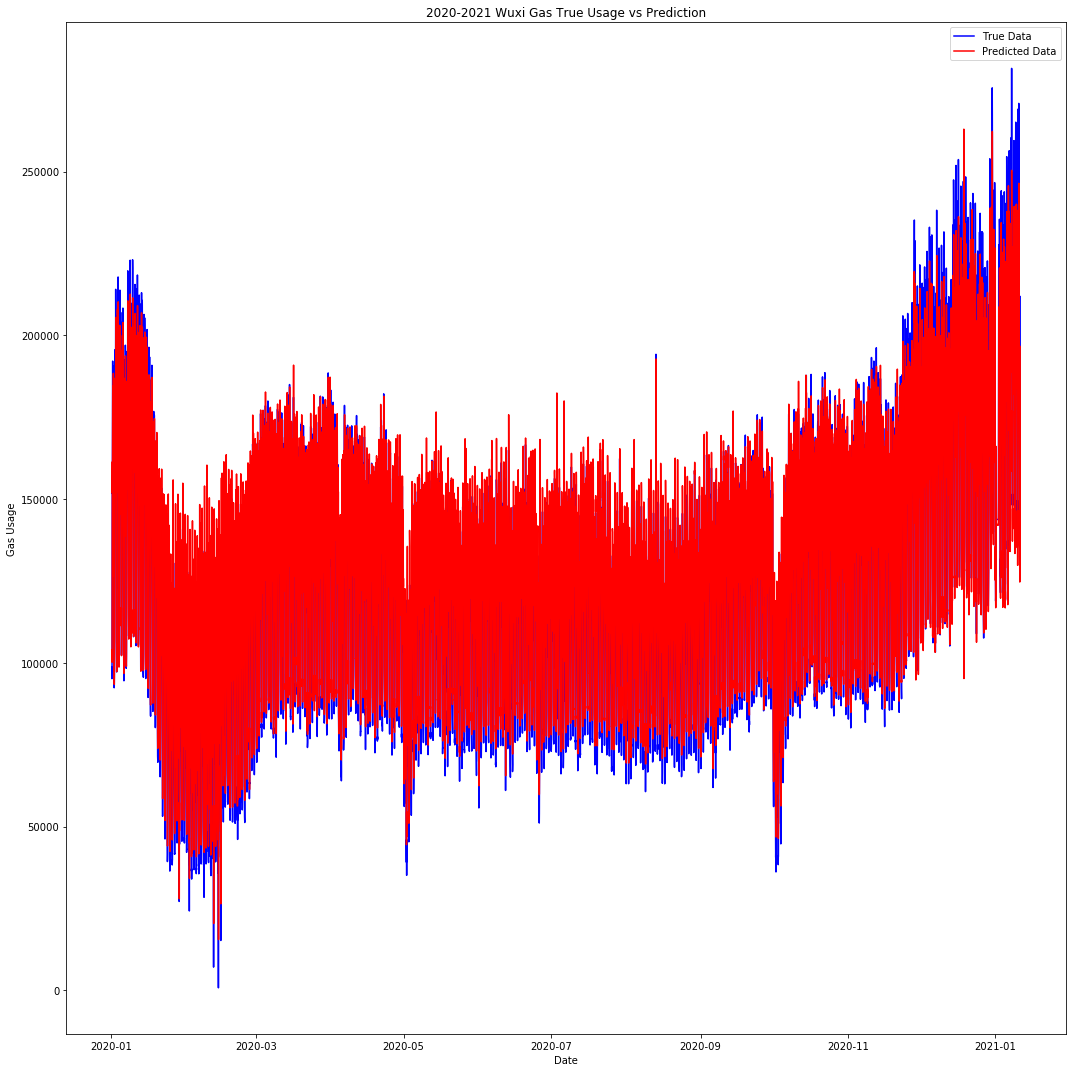

In [143]:
# 画预测图
plt.figure(figsize=(15,15))
plt.title('2020-2021 Wuxi Gas True Usage vs Prediction')
x = series['time'][8215:]
y = series['amount'][8215:]
plt.plot(x, y, color='b', label='True Data')
plt.plot(x, inv_yhat, color='r', label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.tight_layout()
plt.legend()
plt.show()

# XGBOOST

In [145]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

# 预处理和划分数据
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 导入模型
import xgboost as xgb

#模型调参的工具
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV

#模型保存工具
from sklearn.externals import joblib

#Error metrics
from sklearn.metrics import mean_squared_error, r2_score

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/hyan1234/opt/anaconda3/envs/LSTM/lib/python3.6/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/hyan1234/opt/anaconda3/envs/LSTM/lib/python3.6/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [146]:
# 用2019-01-01到2019-12-09的数据来训练
values = reframed.values
train = values[:8208]
test = values[8208:]
# split into input and outputs
n_obs = n_hours * n_features
# 有4=(4*1)列数据，取前3=(3*1) 列作为X，倒数第1列=(第4列)作为Y
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
# 将数据转换为3D输入，timesteps=3，3条数据预测1条 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8208, 7) (8208,)
(9029, 7) (9029,)
(8208, 7, 1) (8208,) (9029, 7, 1) (9029,)


In [ ]:
# setup regressor
xgb_model = xgb.XGBRegressor() 
# performance a grid search
tweaked_model = GridSearchCV(
    xgb_model,   
    {
        'max_depth':[1,2,5,10,20],
        'n_estimators':[20,30,50,70,100],
        'learning_rate':[0.1,0.2,0.3,0.4,0.5]
    },   
    cv = 3,   
    verbose = 1,
    n_jobs = -1,  
    scoring = 'neg_median_absolute_error', 
tweaked_model.fit(X_train[:-1],y_train)
print('Best: %f using %s'%(tweaked_model.best_score_, tweaked_model.best_params_))